# Part 4: Transfer

Deep neural networks learn representations of data that can be helpful for related but different tasks than that for which they were originally trained. This is a valuable property, because it suggests that some of the representation learning can be **transferred** to a different related task.

In this part of the assignment, you will load a pre-trained neural network originally trained for one image recognition task and will apply and fine tune that model for a related but different image recognition task on a different dataset, all using PyTorch. Specifically, we will use a pretrained ResNet model (a convolutional neural network with a residual component) to classify 32 by 32 pixel color images of animals, automobiles, planes, and ships (10 classes in total).

**Learning objectives.** You will:
1. Apply a pre-trained ResNet model for a related but different image recognition task by retraining the final decision layer.
2. Fine tune a pre-trained model to improve model performance on a new task.
3. Evaluate different learning hyperparameters and model architecture choices by evaluating validation performance
4. Accelerate neural network training and inference using a graphics processing unit (GPU) with software support in PyTorch.
5. Compute and visualize gradient class activation maps as model saliancy visualizations
6. Consider the role of interpretability and explainability in machine learning models

While it is possible to complete this part using CPU compute, it may be very slow. To accelerate your training, consider using GPU resources such as `CUDA` through the CS department cluster. Alternatives include Google colab or local GPU resources for those running on machines with GPU support.

The following code imports relevant PyTorch modules, downloads the dataset, splits into a train, validation, and test dataset, and prepares PyTorch dataloaders for batching.

In [1]:
# Run but DO NOT MODIFY this code

# Import libraries
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Load CIFAR-10 dataset
train_data = datasets.CIFAR10(root="data", train=True, download=True, transform=ToTensor())
train_set, val_set = random_split(train_data, [0.8, 0.2])
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=ToTensor())

# Prepare DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


The following code then visualizes some random examples of the training data.

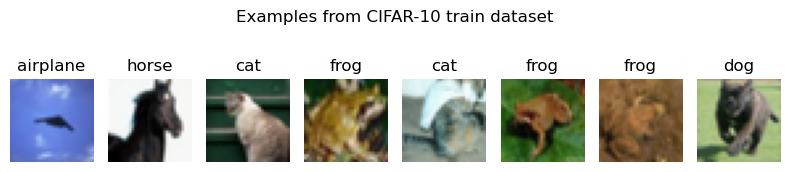

In [2]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
"horse", "ship", "truck"]

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get some random training images
dataiter = iter(torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True))
images, labels = next(dataiter)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(1, 8, figsize=(8, 2))
fig.suptitle('Examples from CIFAR-10 train dataset', fontsize=12)

# Plot 8 images
for i, ax in enumerate(axs.flat):
    ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    ax.set_title(f"{classes[labels[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Task 1

The following code imports a pretrained ResNet model that was trained to classify color images on the ImageNet dataset. The images in that dataset represent 1,000 possible classes. By contrast, the images in our dataset are classified into one of just 10 classes.

Unsurprisingly, you will find that you cannot directly apply the ResNet model to prediction on our CIFAR-10 dataset. However, we can achieve surprising performance by **only changing the output layer** of the model, leaving all parameters prior to the final layer unchanged (setting `requires_grad = False` for an element of `model.parameters()` should accomplish this freezing). Freeze the model parameters and replacing the final `.fc` layer with a fully connected [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) with just 10 output units.

In [3]:
pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


In [10]:
from torchvision import models
import torch.nn as nn

model = models.resnet18(pretrained=True)

# Write code to finish task 1 here

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features  
model.fc = nn.Linear(num_ftrs, 10) 

## Task 2

Use [minibatch stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) to optimize the parameters of **the output layer only** (which should be what happens if you completed task 1 correctly) on the training data by optimizing the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Evaluate and report the validation accuracy (accuracy on the heldout validation set) at the end of each epoch of training (optionally, you may wish to report the training or validation [loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)). You may use Tensorboard but are not required to do so.

You should be able to achieve a validation accuracy of 40% or better without changing any model parameters except the last layer, though you may need to experiment with the training hyperparameters to accomplish this. When you are satisfied, also evaluate and report the accuracy of your model on the heldout test data.

Briefly list in English all of the hyperparameters you chose for the training of your final model.

In [5]:
# Write code for task 2 here
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad() 

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Back pass
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    model.eval() 
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')

correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_accuracy = 100 * correct / total
print(f'Test Accuracy: {final_accuracy:.2f}%')

Epoch [1/10], Loss: 2.0222
Validation Accuracy: 40.10%
Epoch [2/10], Loss: 1.9869
Validation Accuracy: 41.15%
Epoch [3/10], Loss: 1.9742
Validation Accuracy: 38.77%
Epoch [4/10], Loss: 2.0116
Validation Accuracy: 41.48%
Epoch [5/10], Loss: 1.9817
Validation Accuracy: 39.91%
Epoch [6/10], Loss: 1.9845
Validation Accuracy: 39.87%
Epoch [7/10], Loss: 1.9814
Validation Accuracy: 41.59%
Epoch [8/10], Loss: 1.9960
Validation Accuracy: 39.30%
Epoch [9/10], Loss: 1.9634
Validation Accuracy: 41.55%
Epoch [10/10], Loss: 1.9661
Validation Accuracy: 41.30%
Test Accuracy: 41.30%


*Briefly explain for task 2 here*

## Task 3

We can achieve a higher level of performance by **fine-tuning** the entire pre-trained model on the new task. Start with the original pretrained ResNet model and replace the output layer as before, but this time **do not** freeze any of the other parameters.

Use [minibatch stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) to fine tune the parameters (that is, normal training, but usually with a relatively small learning rate) on the training data by optimizing the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Evaluate and report the validation accuracy (accuracy on the heldout validation set) at the end of each epoch of training (optionally, you may wish to report the training or validation [loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)). You may use Tensorboard but are not required to do so.

You should be able to achieve a validation accuracy of 75% or better, though you may need to experiment with the training hyperparameters to accomplish this. When you are satisfied, also evaluate and report the accuracy of your model on the heldout test data.

Briefly list in English all of the hyperparameters you chose for the training of your final model.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision.datasets as datasets

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

model = models.resnet18(pretrained=True)

num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10
for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()  # Zero gradients

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Back pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

    model.eval() 
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_accuracy = 100 * correct / total
print(f'Test Accuracy: {final_accuracy:.2f}%')


Epoch [1/10], Loss: 1.1037
Validation Accuracy: 73.78%
Epoch [2/10], Loss: 0.6781
Validation Accuracy: 77.11%
Epoch [3/10], Loss: 0.5071
Validation Accuracy: 78.17%
Epoch [4/10], Loss: 0.3939
Validation Accuracy: 78.53%
Epoch [5/10], Loss: 0.3013
Validation Accuracy: 78.96%
Epoch [6/10], Loss: 0.2241
Validation Accuracy: 79.67%
Epoch [7/10], Loss: 0.1786
Validation Accuracy: 79.18%
Epoch [8/10], Loss: 0.1433
Validation Accuracy: 79.27%
Epoch [9/10], Loss: 0.1158
Validation Accuracy: 78.95%
Epoch [10/10], Loss: 0.1013
Validation Accuracy: 79.44%
Test Accuracy: 78.61%


The hyperparameters we use are a pre-trained ResNet18 architecture, with the last fully connected layer modified to output 10 classes for FashionMNIST this time to allow for extraction while addressing the vanishing gradient problem. A batch size of 64 was used for training, validation, and testing, with a learning rate of 0.001 and momentum set to 0.9 for the SGD optimizer. The loss function used is CrossEntropyLoss, and the model was trained for 10 epochs.

We asked GPT to help us structure the dataloader before the training loop, ensuring correct implementation of forward and backward passes, gradient handling, and loss calculations. Additionally, GPT provided debugging strategies and methods on integrating TensorBoard to visualize training metrics.

## Task 4

Though they can achieve impressive performance, it can be very challenging to make sense of how deep learning models make predictions. One common approach to analyzing deep convolutional neural networks for image recognition tasks is to compute a saliancy map, a heat map over an image input that highlights the regions most contributing activation scores to the decision layer of the model. 

For example, the [The Bishop Deep Learning Book](https://www.bishopbook.com/), Section 10.3.3, describes the Gradient Class Activation Map (Grad-CAM) method introduced by [Selvaraju and all 2016](https://arxiv.org/abs/1610.02391). Given an image and label, this technique computes the derivatives of the score for the label's output unit with respect to the weights of (usually) the last convolutional layer. These are used to compute a weighted average of the feature maps of the final convolutional layer, which is then upsampled and projected as a heatmap onto the original image. Conceptual at a high level, the idea is that this estimates the regions of the image that provide significant contributions to the activation for the given output unit.


Below, we install and import the `pytorch-grad-cam` package, which you can [see on Github here](https://github.com/jacobgil/pytorch-grad-cam/tree/master). Compute and visualize the Grad-CAM for the **original** pretrained (**not** fine-tuned) ResNet model for each of the three images in `cat_images` (`tuxedo_cat.jpg`, `kittens.jpg`, and `dog_cat.jpg`), each with respect to the `cat` label. 

We recommend reviewing the [introductory documentation here](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html) to familiarize yourself with the usage of `GradCAM`, especially [this minimal example](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html#using-from-code-as-a-library) which also uses a ResNet model (a slightly larger one than used here). Note also the use of `ClassifierOutputTarget(281)`; 281 is the index corresponding to `cat` in the imagenet dataset on which ResNet was trained, and that's what you'll be looking for in these example images as well, so you can use it in the same way.

You will probably need to install the grad-cam package. To do so, uncommonent and run the following cell.

In [7]:
pip install grad-cam

Note: you may need to restart the kernel to use updated packages.


Now you should be able to import from the `pytorch_grad_cam` package.

In [8]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

C:\Users\micha\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\micha\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


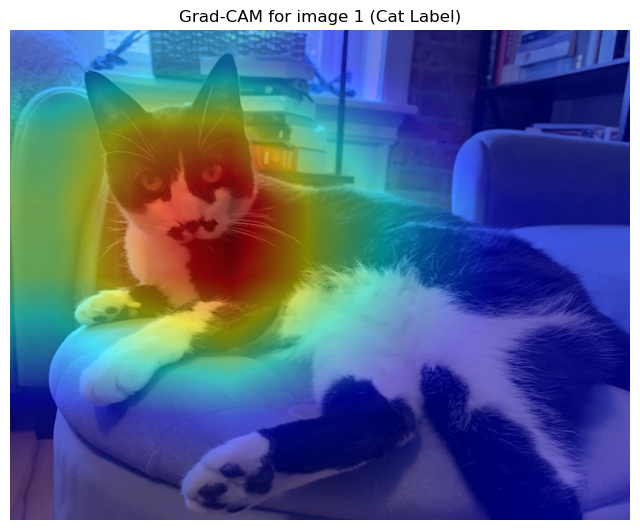

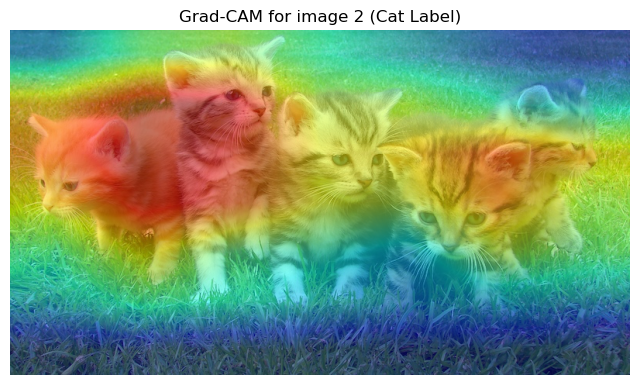

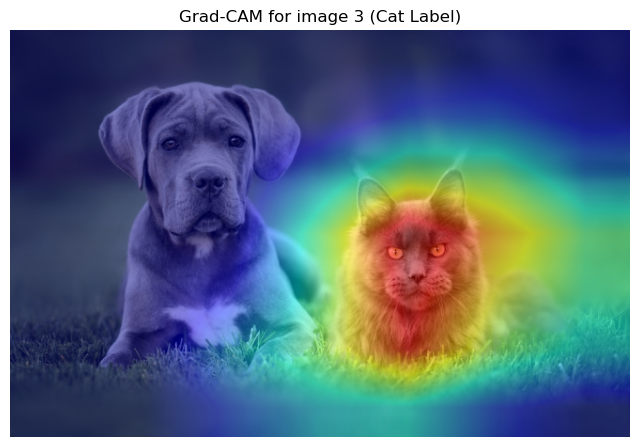

In [9]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2  # OpenCV for resizing

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(pretrained=True).to(device)
model.eval() 

# Image preprocessing for ResNet (resize to 224x224, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_paths = [
    'cat_images/tuxedo_cat.jpg',
    'cat_images/kittens.jpg',
    'cat_images/dog_cat.jpg'
]

images = [Image.open(img_path).convert('RGB') for img_path in image_paths]

input_tensors = [transform(img).unsqueeze(0).to(device) for img in images]  # Add batch dimension and move to device

target_category = [ClassifierOutputTarget(281)]

cam = GradCAM(model=model, target_layers=[model.layer4[-1]])

for i, img_tensor in enumerate(input_tensors):
    grayscale_cam = cam(input_tensor=img_tensor, targets=target_category)

    rgb_img = np.array(images[i]) / 255.0  # Normalize pixel values to [0, 1]
    heatmap = cv2.resize(grayscale_cam[0], (rgb_img.shape[1], rgb_img.shape[0]))

    cam_image = show_cam_on_image(rgb_img, heatmap, use_rgb=True)

    plt.figure(figsize=(8, 8))
    plt.imshow(cam_image)
    plt.title(f"Grad-CAM for image {i+1} (Cat Label)")
    plt.axis('off')
    plt.show()


We prompted GPT the most here, which helped us set up the ResNet model and load it onto the appropriate device. We consulted GPT on the correct preprocessing steps for the images, including resizing and normalizing them to fit the ResNet input requirements. Lastly, we needed help on implementing and utilizing the pytorch Grad-CAM, specifically in configuring the Grad-CAM model, selecting the target layer, and applying the CAM to the input images.

*Optional Extra challenge* If you would like an extra challenge for your PyTorch programming, you could try implementing Grad-CAM yourself instead of using the library. The main challenge is that some of the derivatives you need for computing the feature map weights are not stored by default because they are not leaf nodes in the PyTorch computational graph. Common approaches to address this involve modifying the `forward` method, potentially registering a [Pytorch `hook`](https://pytorch.org/docs/stable/generated/torch.Tensor.register_hook.html). Don't try this until you have finished the rest of the assignment, and not that it is not for points.

## Task 5

Not everyone agrees that saliency maps like those you computed above are necessarily helpful for understanding machine learning models. Read at least Sections 1-2 (about 5 pages) of [Dr. Rudin](https://users.cs.duke.edu/~cynthia/)'s [2019 Nature perspective article](https://arxiv.org/abs/1811.10154). Then write 1-2 paragraphs in response to each of the following two questions.

1. Summarize the difference between **interpretable** and **explainable** machine learning models as described in the article.
2. Do you think that saliency maps such as from Grad-CAM are helpful for explaining image recognition models? Briefly explain why or why not.

Professor Rudin describes that the difference between interpretable and explainable machine learning models are that interpretable models are designed to be transparent and understandable from the start, meaning users can directly see how inputs affect outputs. In contrast, explainable models rely on after the fact explanations for black-box models, which are often complex or proprietary resulting in the lack of processing transparency. The issue with explainable models is that the explanations often do not represent the original model’s computations in a way which allows the user to adequately understant the decision making process in an informative way, leading to potential errors or misleading conclusions.


Regarding saliency maps like Grad-CAM, Professor Rudin critiques their usefulness in explaining image recognition models. While saliency maps highlight which part of an image a model focuses on, they often fail to explain how the model is using that information to make a decision. This means that saliency maps might show similar visual patterns for different classifications, such as identifying both a Siberian husky and a flute, without providing insight into the specific reasoning. Because of this, we think saliency maps are an incomplete form of explanation that can mislead users into thinking the model is working correctly, even when it might not be. 